In [10]:
import robot_plotter as rp
import models_functions as mf
import traj
import numpy as np
import matplotlib.pyplot as plt
import robot_sim as sim
import sim_helper_funcs as hfunc

## Script for running many simulations of a particular trajectory
Run many simulations with set random seeds, for use with ANEES purposes. 

This one is for Luft et al's implementation of the CL algorithm

In [11]:
# generate reference trajectory
dt = 0.01

pos1, y_IMU1_base, xa1 = hfunc.path1_slow(dt)
pos2, y_IMU2_base, xa2 = hfunc.path2_slow(dt)
pos3, y_IMU3_base, xa3 = hfunc.path3_slow(dt)

pos_len = pos1.shape[1] # Assumes that all paths have the same length
#pos_len = 1000 # overwrite for debugging

# Generate anchors position:
xanc1, xanc2 = hfunc.anc_setup1()
xanc3, xanc4 = hfunc.anc_setup2()

In [12]:
R_b = 0.0009
R_r = 0.001
R_w = 0.0002
R_a = 0.004

#Q=np.diag([0.1, 8.0, 8.0, 0.000001, 0.00001, 0.00001])
#R=np.diag([R_b, R_r, R_w, R_a, R_a]) # approx vaules from datasheets
#P=np.diag([0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.0004,0.1,0.1]) # Initialize with system noise for bias

anchor1 = sim.Anchor(x0=xanc1)
anchor2 = sim.Anchor(x0=xanc2)
anchor3 = sim.Anchor(x0=xanc3)
anchor4 = sim.Anchor(x0=xanc4)


In [13]:
list_seeds = [1061]
#1061, 1, 19001, 7871871, 2289, 91667, 8, 6119077, 47, 5514
seeds_num = len(list_seeds)
# Initialize logs
x_logL1 = np.zeros((mf.STATE_LEN, pos_len, seeds_num))
P_logL1 = np.zeros((mf.STATE_LEN, mf.STATE_LEN, pos_len, seeds_num))
x_logL2 = np.zeros((mf.STATE_LEN, pos_len, seeds_num))
P_logL2 = np.zeros((mf.STATE_LEN, mf.STATE_LEN, pos_len, seeds_num))
x_logL3 = np.zeros((mf.STATE_LEN, pos_len, seeds_num))
P_logL3 = np.zeros((mf.STATE_LEN, mf.STATE_LEN, pos_len, seeds_num))
nis_log1 = np.zeros((pos_len, seeds_num))
nis_log2 = np.zeros((pos_len, seeds_num))
nis_log3 = np.zeros((pos_len, seeds_num))
abs_e_log1 = np.zeros((6, pos_len, seeds_num))
abs_e_log2 = np.zeros((6, pos_len, seeds_num))
abs_e_log3 = np.zeros((6, pos_len, seeds_num))

# Sim settings
sr = R_r
sb = R_b
r_w = R_w
r_a = R_a
sim_max_dist = 50
thres = 12 # 99.5 % confidence
thres_IMU = 14.5 # 99.5 % confidence
out_freq = np.array([[0.0],[0.0],[0.0]]) # an outlier every second on average
bias_base = np.array([[0.07],[0.2],[0.2]]) # max magnitude of bias
amb = False

#thres = 0
#thres_IMU = 0
#sr=0
#sb=0
#r_w = 0
#r_a = 0

for j in range(seeds_num):
    print("seed: " + str(list_seeds[j]))
    # random bias:
    bias_vec = 2*bias_base*(np.random.rand(3, 1) - 0.5)
    bias_vec =  np.array([[0.0],[0],[0]])

    np.random.seed(list_seeds[j])
    y_IMU1 = traj.gen_noise(y_IMU1_base.copy(), dt=dt, sigma=np.diag([r_w, r_a, r_a]), bias=bias_vec, out_freq=out_freq)
    y_IMU2 = traj.gen_noise(y_IMU2_base.copy(), dt=dt, sigma=np.diag([r_w, r_a, r_a]), bias=bias_vec, out_freq=out_freq)
    y_IMU3 = traj.gen_noise(y_IMU3_base.copy(), dt=dt, sigma=np.diag([r_w, r_a, r_a]), bias=bias_vec, out_freq=out_freq)

    # Run LUFT algorithm
    robotL1 = sim.robot_luft(x0=xa1, path=pos1, imu=y_IMU1, dt=dt, id=111)
    robotL2 = sim.robot_luft(x0=xa2, path=pos2, imu=y_IMU2, dt=dt, id=222)
    robotL3 = sim.robot_luft(x0=xa3, path=pos3, imu=y_IMU3, dt=dt, id=333)

    for i in range(pos_len-1):
        robotL1.predict(imu_correct=True, thres=thres_IMU)
        robotL2.predict(imu_correct=True, thres=thres_IMU)
        robotL3.predict(imu_correct=True, thres=thres_IMU)
        # Set up a measurement pattern similar to the used communication protocol
        # First module:
        if (i > 0 and i % 100 == 0):
            hfunc.updateAllLuft(robotL1, [anchor1, anchor2, anchor3, anchor4], [robotL2, robotL3], sr=sr, sb=sb, max_dist=sim_max_dist, thres=thres, amb=amb)
        # Second module:
        if (i > 0 and (i+33) % 100 == 0):
            hfunc.updateAllLuft(robotL2, [anchor1, anchor2, anchor3, anchor4], [robotL1, robotL3], sr=sr, sb=sb, max_dist=sim_max_dist, thres=thres, amb=amb)
        # Third module:
        if (i > 0 and (i+66) % 100 == 0):
            hfunc.updateAllLuft(robotL3, [anchor1, anchor2, anchor3, anchor4], [robotL1, robotL2], sr=sr, sb=sb, max_dist=sim_max_dist, thres=thres, amb=amb)
    
    # Save estimates and covariances:
    # Slicing, incase we want to run a shorter simulation
    x_logL1[:,:,j] = robotL1.x_log[:,:pos_len]
    P_logL1[:,:,:,j] = robotL1.P_log[:,:,:pos_len]
    x_logL2[:,:,j] = robotL2.x_log[:,:pos_len]
    P_logL2[:,:,:,j] = robotL2.P_log[:,:,:pos_len]
    x_logL3[:,:,j] = robotL3.x_log[:,:pos_len]
    P_logL3[:,:,:,j] = robotL3.P_log[:,:,:pos_len]
    nis_log1[:,j] = robotL1.nis_IMU[:pos_len]
    nis_log2[:,j] = robotL2.nis_IMU[:pos_len]
    nis_log3[:,j] = robotL3.nis_IMU[:pos_len]
    abs_e_log1[:,:,j] = sim.error_bp(robotL1, bias_vec)[:,:pos_len]
    abs_e_log2[:,:,j] = sim.error_bp(robotL2, bias_vec)[:,:pos_len]
    abs_e_log3[:,:,j] = sim.error_bp(robotL3, bias_vec)[:,:pos_len]


seed: 1061
Robot 333 sees an anchor at time 0.35000000000000003
Anchor out of range for robot 333 at time 0.35000000000000003
Anchor out of range for robot 333 at time 0.35000000000000003
Anchor out of range for robot 333 at time 0.35000000000000003
Robot 333 sees robot 111 at time 0.35000000000000003
Adding new robot: 333
Adding new robot: 111
Robot 333 sees robot 222 at time 0.35000000000000003
Adding new robot: 333
Adding new robot: 222
Robot 222 sees an anchor at time 0.68
Anchor out of range for robot 222 at time 0.68
Robot 222 sees an anchor at time 0.68
Anchor out of range for robot 222 at time 0.68
Robot 222 sees robot 111 at time 0.68
Adding new robot: 222
Adding new robot: 111
Robot 222 sees robot 333 at time 0.68
Robot 111 sees an anchor at time 1.01
Anchor out of range for robot 111 at time 1.01
Robot 111 sees an anchor at time 1.01
Anchor out of range for robot 111 at time 1.01
Robot 111 sees robot 222 at time 1.01
Robot 111 sees robot 333 at time 1.01
Robot 333 sees an an

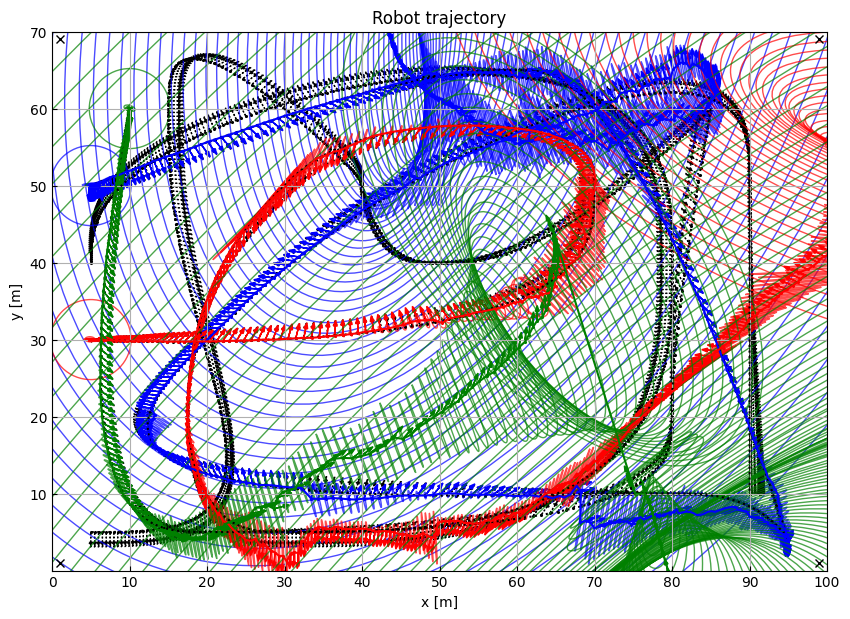

In [14]:
# Plot the choosen simulation:
s_idx = 0

# Plot ground truth
fig, ax = rp.setup_plot()
rp.plot_position(ax, pos1[:,::100], color='black', marker=None, linestyle=':', label='Robot 1 reference')
rp.plot_position(ax, pos2[:,::100], color='black', marker=None, linestyle=':', label='Robot 2 reference')
rp.plot_position(ax, pos3[:,::100], color='black', marker=None, linestyle=':', label='Robot 3 reference')

# Plot states of robots:
rp.plot_position2(ax, x_logL1[:,::100,s_idx], P_logL1[:,:,::100,s_idx], color='blue', marker=None, label='Robot 1 trajectory')
rp.plot_position2(ax, x_logL2[:,::100,s_idx], P_logL2[:,:,::100,s_idx], color='red', marker=None, label='Robot 2 trajectory')
rp.plot_position2(ax, x_logL3[:,::100,s_idx], P_logL3[:,:,::100,s_idx], color='green', marker=None, label='Robot 3 trajectory')

anchor1.draw_position(ax, color='black')
anchor2.draw_position(ax, color='black')
anchor3.draw_position(ax, color='black')
anchor4.draw_position(ax, color='black')

#ax.legend()

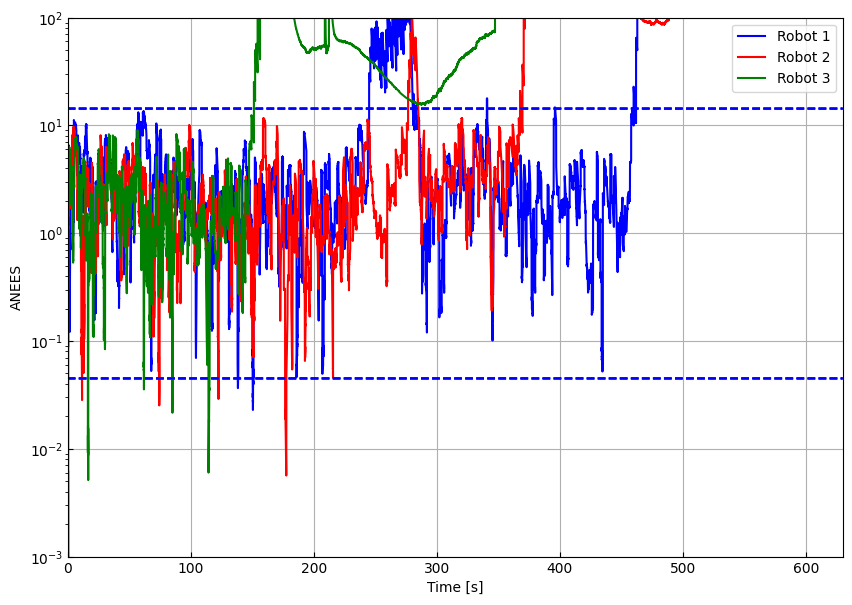

In [15]:
# Plot metrics:
# ANEES analysis
# If higher than confidence interval, then the estimate is overconfident
fig, ax_anees = plt.subplots(1, figsize=(10,7))
anees_sel = np.array([[True],[False],[False]])
pos_ind = [0, 2, 3]
#anees_sel = np.array([[False],[False]])
#pos_ind = [2, 3]
rp.plot_ANEES(ax_anees, 
             x_est=x_logL1[pos_ind,:],
             x_true=robotL1.path[:3,:], 
             P=P_logL1[np.ix_(pos_ind, pos_ind)], 
             rad_sel=anees_sel,
             dt=dt,
             prob=0.995,
             label='Robot 1')
rp.plot_ANEES(ax_anees, 
             x_est=x_logL2[pos_ind,:],
             x_true=robotL2.path[:3,:], 
             P=P_logL2[np.ix_(pos_ind, pos_ind)], 
             rad_sel=anees_sel,
             dt=dt,
             prob=0.995,
             color='red',
             label='Robot 2')
rp.plot_ANEES(ax_anees, 
             x_est=x_logL3[pos_ind,:],
             x_true=robotL3.path[:3,:], 
             P=P_logL3[np.ix_(pos_ind, pos_ind)], 
             rad_sel=anees_sel,
             dt=dt,
             prob=0.995,
             color='green',
             label='Robot 3')
ax_anees.set_ylim([0.001, 100])

ax_anees.legend()

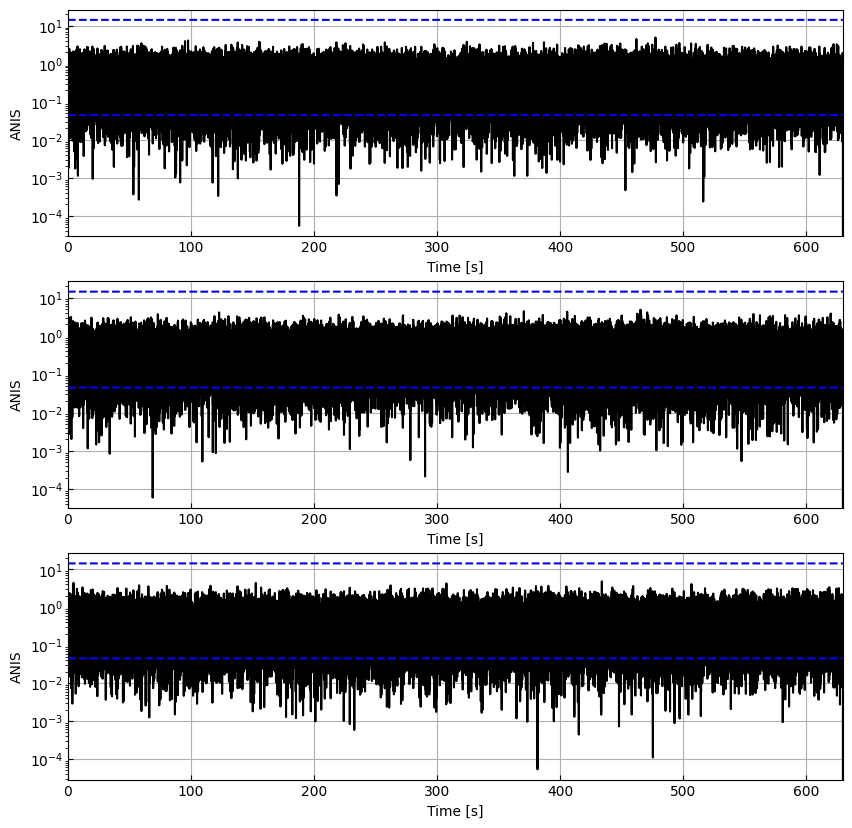

In [16]:
# ANIS analysis
fig, axnis = plt.subplots(3, figsize=(10,10))
# Three df
rp.plot_ANIS(ax=axnis[0], nis=nis_log1, df=3, dt=dt, prob=0.995, color='black')
rp.plot_ANIS(ax=axnis[1], nis=nis_log2, df=3, dt=dt, prob=0.995, color='black')
rp.plot_ANIS(ax=axnis[2], nis=nis_log3, df=3, dt=dt, prob=0.995, color='black')

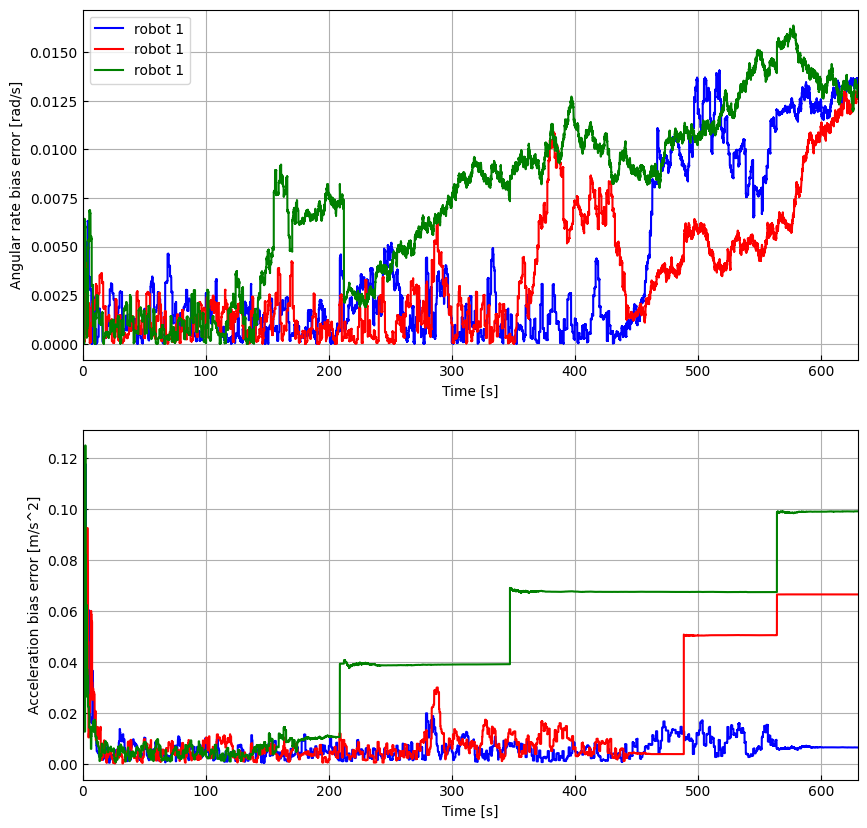

In [17]:
# Plot the absolute bias error:
fig, axbp = plt.subplots(2, figsize=(10,10))

rp.plot_abs_avg(axbp, abs_e_log1, dt=dt, pos=False, colors=['blue', 'blue'], labels=['robot 1', 'robot 1'])
rp.plot_abs_avg(axbp, abs_e_log2, dt=dt, pos=False, colors=['red','red'], labels=['robot 1', 'robot 1'])
rp.plot_abs_avg(axbp, abs_e_log3, dt=dt, pos=False, colors=['green', 'green'], labels=['robot 1', 'robot 1'])
axbp[0].legend()


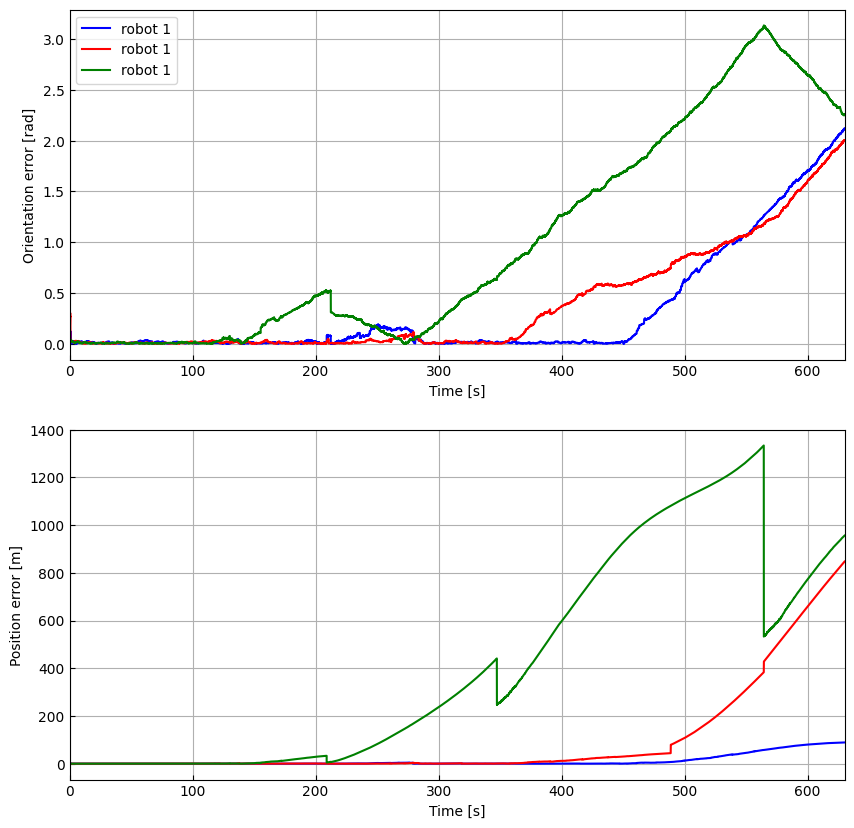

In [18]:
# Plot the absolute positioning error:
fig, axpos = plt.subplots(2, figsize=(10,10))

rp.plot_abs_avg(axpos, abs_e_log1, dt=dt, pos=True, colors=['blue', 'blue'], labels=['robot 1', 'robot 1'])
rp.plot_abs_avg(axpos, abs_e_log2, dt=dt, pos=True, colors=['red','red'], labels=['robot 1', 'robot 1'])
rp.plot_abs_avg(axpos, abs_e_log3, dt=dt, pos=True, colors=['green', 'green'], labels=['robot 1', 'robot 1'])
axpos[0].legend()

Interesting things to check:
- Anchor placements: If they are very close together, does the estimate then suffer?
- Daisy chain length: If there is a very long chain of drones with only these at the very end having connection to anchors, how does that affect the localization?
- Can a large group still keep consistency?
- What if communication is cut out at various points?
- How long can a group stay consistent, after communication is cut out? and can they recover?
- Outliers! (Important - how does the system handle these?)
    Only with anchors/IMU out: Filter has trouble maintaing consistency, but does not diverge 
- Fast drones with fast turning.
- Lot of orientation shifts (will ML fail?)

TODO:
- Try increasing covariance of measurments, ONLY for relative measurements, to prioritize anchor measurements better
- Dynamic thresholding: Based on the covariance of the bias estimates, decrease the thresholds
- Maximum threshold - just do handtuning

More notes:
- It seems that daisy chains are more susepticle to being thrown off by ML errors - its very dependent on both measurements being correct. If one happens, the system is then having a hard time to recover from it
